# Práctica de agrupamiento

## Autoría

* Nombre: Jorge Cabrera Rodríguez
* Email: alu0101351773@ull.edu.es
* Universidad: Universidad de La Laguna
* Máster: Ciberseguridad e Inteligencia de Datos
* Repositorio: [enlace](https://github.com/alu0101351773/ECBD_practicas.git)

## Introducción al dataset

En la base de datos _mallCustomers.csv_ se recogen los datos de 200 clientes de un centro comercial. El fichero consta de 5 variables, incluyendo el identificador de cada cliente (**CustomerID**).

Las variables en cuestión son las siguientes:

| Variable       | Descripción                                    | Valores       |
| -------------- | ---------------------------------------------- | ------------- |
| `Customer ID`    | identificador del cliente                      | Numérico      |
| `Gender`         | género del cliente                             | Male / Female |
| `Age`            | edad del cliente                               | Numérico      |
| `Annual.income`  | ingresos anuales del cliente                   | Numérico      |
| `Spending.score` | puntuación dada al cliente por el supermercado | Numérico      |

In [22]:
import pandas as pd

data = pd.read_csv(
    "../data/Base de datos - mallCustomers.csv"
)

data.head()

,CustomerID,Genre,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Ya que el ID de los usuarios es irrelevante a la hora de realizar el agrupamiento, se ha decidido eliminar esta columna del dataset.

In [23]:
if 'CustomerID' in data.columns:
    data.drop(columns = ['CustomerID'], inplace = True)
data.head()

,Genre,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Construcción de agrupamientos

### Agrupamiento con k-medias _(k-means)_

#### Elección de subconjunto de datos

Lo primero que podemos hacer para visualizar los datos es representarlos mediante nubes de puntos, una por cada par de variables. De esta forma, podemos hacernos una idea de cómo se distribuyen los datos y si existen agrupamientos claros.

Para ello, vamos a graficar las siguientes variables:

* `Age` y `Annual.income`
* `Age` y `Spending.score`
* `Annual.income` y `Spending.score`

Text(970.81045751634, 0.5, 'Puntuación de gasto')

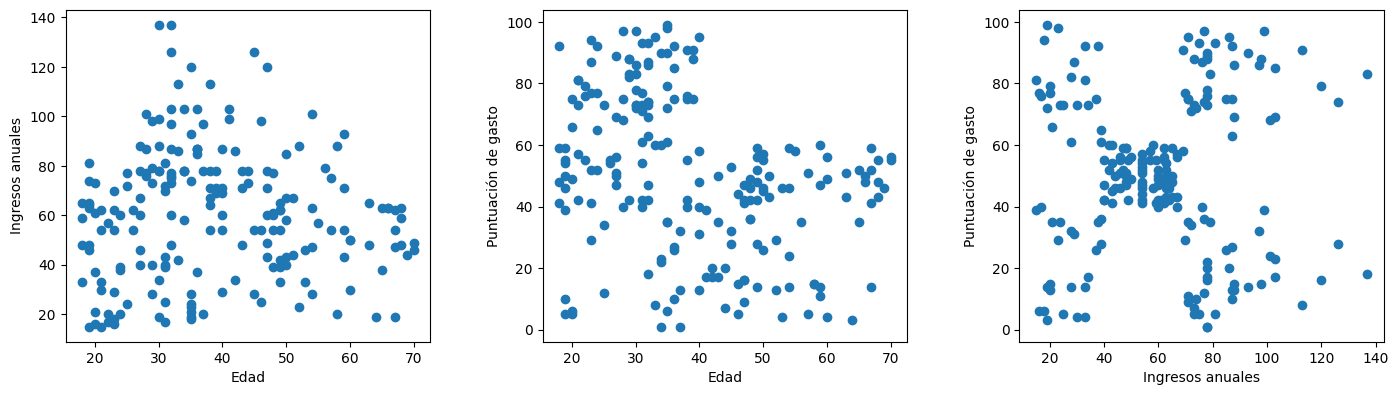

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)

ax1.scatter(data['Age'], data['Annual Income'])
ax1.set_xlabel('Edad')
ax1.set_ylabel('Ingresos anuales')

ax2.scatter(data['Age'], data['Spending Score'])
ax2.set_xlabel('Edad')
ax2.set_ylabel('Puntuación de gasto')

ax3.scatter(data['Annual Income'], data['Spending Score'])
ax3.set_xlabel('Ingresos anuales')
ax3.set_ylabel('Puntuación de gasto')

Podemos observar una clara agrupación entre las variables `Spending Score` y `Annual Income`, por lo que podría ser interesante comenzar por ese par de variables para realizar el agrupamiento.

Comenzaremos con un _clustering_ de 5 grupos, para probar el funcionamiento del algoritmo de forma primitiva. Más adelante, calcularemos el número de grupos acorde al criterio del codo (_elbow method_).

#### Creación del agrupamiento

Text(0.5, 1.0, 'Clustering con KMeans')

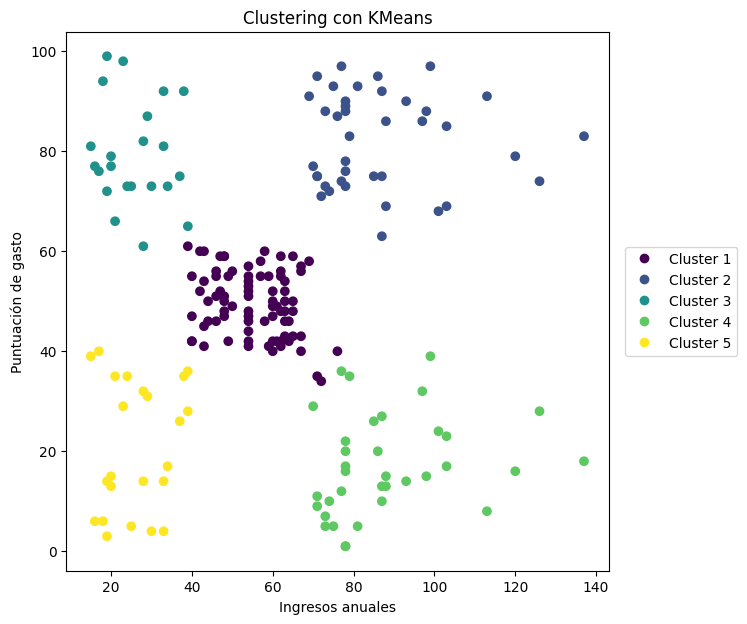

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state = 42, n_init = 'auto')
kmeans.fit(data[['Spending Score', 'Annual Income']])

labels = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize = (7, 7))

res = ax.scatter(
    data['Annual Income'],
    data['Spending Score'],
    c = labels
)
ax.set_xlabel('Ingresos anuales')
ax.set_ylabel('Puntuación de gasto')
ax.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1.25, 0.5)
)
ax.set_title('Clustering con KMeans')

Podemos ver un agrupamiento con 5 grupos bastante bien distanciados y definidos. Ahora calcularemos el valor de información retenida de cada posible valor de _k_ para ver cuál es el número óptimo de grupos.

Para ello, graficaremos la información retenida, y para aquel valor de K tal que
el crecimiento a partir del mismo (`growth`) sea menor que un determinado
umbral (`threshold`), determinaremos ese punto como valor óptimo de _k_.

In [26]:
import numpy as np

def information_value(data: pd.DataFrame, cluster_number: int = 1) -> float:
    kmeans = KMeans(n_clusters = cluster_number, random_state = 42, n_init = 'auto')
    kmeans.fit(data)

    labels = kmeans.labels_
    total_variance = np.var(data, axis = 0).sum()
    cluster_centers = kmeans.cluster_centers_
    clustered_data = cluster_centers[labels]
    explained_variance = np.var(clustered_data, axis=0).sum()

    return explained_variance / total_variance    

In [27]:
def elbow_value(info_values: list, growth_threshold: int = 0.02) -> int:

    for i, value in enumerate(info_values):
        growth = info_values[i + 1] - value
        if growth < growth_threshold:
            return i

In [28]:
def plot_elbow_chart(k_values: list, info_values: list, top_index: int):
    _, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.plot(k_values, info_values, marker = 'o')
    ax.set_xlabel('Número de clusters')
    ax.set_ylabel('Valor de la información')
    ax.set_title('Valor de la información para diferentes números de clusters')
    ax.axvline(x = top_index + 1, color = 'red', linestyle = '--')

    plt.plot(top_index + 1, info_values[top_index], marker = 'o', color = 'red')

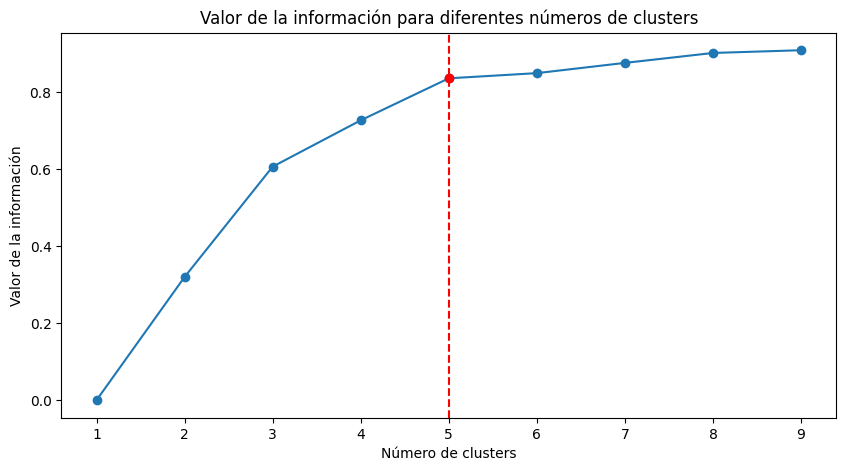

In [29]:
import numpy as np

k_values = np.arange(1, 10)
info_values = []

for i in k_values:
    info_values += [information_value(data[['Annual Income', 'Spending Score']], i)]

top_index = elbow_value(info_values)

plot_elbow_chart(k_values, info_values, top_index)

#### Evaluación del agrupamiento

Como podemos ver, el valor óptimo de _k_ es 5, que es el valor que habíamos elegido anteriormente. La información retenida para este valor de _k_ es la siguiente:

In [30]:
print(f'Información retenida para {top_index + 1} clusters: {info_values[top_index]:.2f}')

Información retenida para 5 clusters: 0.84


Si quisieramos calcular otra medida de rendimiento del agrupamiento, podríamos aplicar el método de la silueta, para comprobar la cohesión de los grupos. Para ello, calcularemos el valor de la silueta para cada punto, y graficaremos dichas siluetas.

In [31]:
import matplotlib.colors as mcolors

def plot_silhouette(n_clusters: int, sil_values: list, sil_avg: float, labels: list):
    _, ax = plt.subplots(1, 1, figsize = (10, 5))

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_sil_values = sil_values[labels == i]
        ith_cluster_sil_values.sort()
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        norm = mcolors.Normalize(vmin = 0, vmax = n_clusters - 1)
        color = plt.cm.viridis(norm(i))

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil_values,
            alpha = 0.7,
            color = color
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))
        y_lower = y_upper + 10


    ax.set_xlabel('Coeficiente de silueta')
    ax.set_ylabel('Cluster')
    ax.set_title('Coeficiente de silueta para k = 5')

    ax.axvline(x = sil_avg, color = 'black', linestyle = '--')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    return ax


Coeficiente promedio de silueta: 0.55


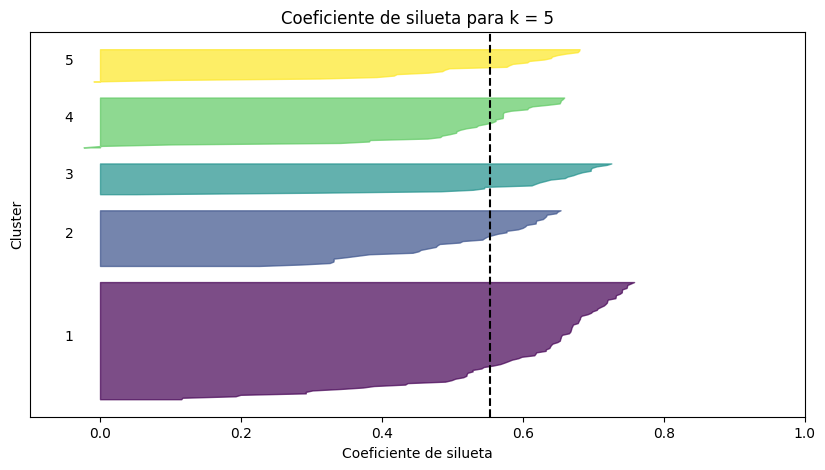

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score


sil_avg = silhouette_score(data[['Annual Income', 'Spending Score']], labels)

sil_values = silhouette_samples(data[['Annual Income', 'Spending Score']], labels)

plot_silhouette(top_index + 1, sil_values, sil_avg, labels)

print(f'Coeficiente promedio de silueta: {sil_avg:.2f}')

El coeficiente medio de silueta de este agrupamiento es de 0.55, lo que indica que el agrupamiento es adecuado. Podemos ver que el _cluster_ 1 es el que parece tener una silueta más extrema: Cuenta con los puntos con silueta más alta (rozando el 0.8), pero también con los puntos con silueta más baja (rozando el 0.2).

El resto de _clusters_ mantienen un valor de silueta más regular, con valores entre 0.3 y 0.7 aproximadamente.

### Agrupamiento jerárquico

#### Elección de subconjunto de datos

Para el agrupamiento jerárquico, vamos a utilizar las mismas variables que para el agrupamiento con k-medias.

#### Creación del modelo

Para este modelo de agrupamiento jerárquico, vamos a comparar el subconjunto de variables `Annual Income` y `Spending Score` con diferentes valores de _k_ para
diferentes métodos de enlace. En este caso calcularemos los diferentes coeficientes cofenéticos y dendrogramas para los métodos de:

* Enlace _single_
* Enlace _centroid_
* Enlace _ward_

Para poder realizar el _clustering_ jerárquico, primero debemos normalizar los
datos. Para ello, utilizaremos la función `StandardScaler` de la librería `sklearn`.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_df = scaler.fit_transform(data[['Annual Income', 'Spending Score']])

Posteriormente calcularemos las matrices de distancia y los dendrogramas para los diferentes métodos de enlace. De esta forma, podremos elegir aquel método cuyo coeficiente cofenético sea mayor.

(0.7218877792812003, array([0.36452421, 0.36767968, 0.36452421, ..., 0.57183643, 0.54622499,
       0.57183643]))
(0.7173982395337909, array([1.66457463, 0.92985952, 1.66457463, ..., 1.97183361, 0.590956  ,
       1.97183361]))
(0.7209128193077099, array([10.14126314,  3.15032521, 10.14126314, ..., 15.62483742,
        0.68237721, 15.62483742]))


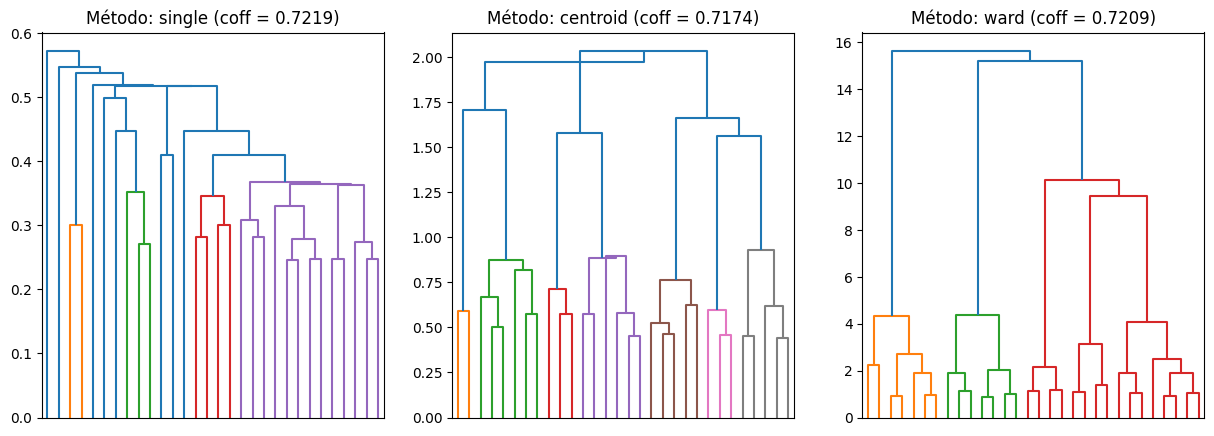

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

subgraphs = [ax1, ax2, ax3]
method_list = ['single', 'centroid', 'ward']

for i, method in enumerate(method_list):
    Z = linkage(cluster_df, method = method)
    cophenet_val = cophenet(Z, pdist(cluster_df))[0]

    print(cophenet(Z, pdist(cluster_df)))

    subgraphs[i].set_title(f'Método: {method} (coff = {cophenet_val:.4f})')
    dendrogram(
        Z,
        ax = subgraphs[i],
        truncate_mode = 'lastp',
        no_labels = True,
    )

Podemos observar que el método _single_ es el que obtiene un coeficiente cofenético mayor ($0.7219$), superando en una milésima al método _ward_ ($0.7209$). Es, por tanto, el método que mejor conserva las distancias originales por.

Para comparar el rendimiento de los tres métodos, los graficaremos para ver los agrupamientos generados en el plano.

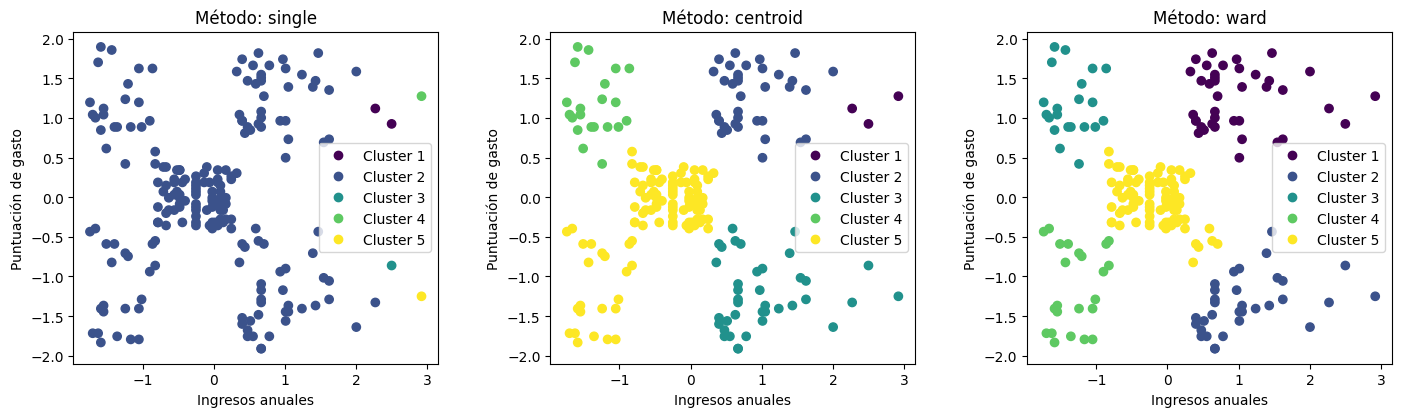

In [35]:
from scipy.cluster.hierarchy import fcluster

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)
ax = [ax1, ax2, ax3]

for i, method in enumerate(method_list):
    Z = linkage(cluster_df, method = method)
    labels = fcluster(Z, 5, criterion = 'maxclust')

    res = ax[i].scatter(
        cluster_df[:, 0],
        cluster_df[:, 1],
        c = labels
    )
    ax[i].set_title(f'Método: {method}')
    ax[i].set_xlabel('Ingresos anuales')
    ax[i].set_ylabel('Puntuación de gasto')

    ax[i].legend(
        handles = res.legend_elements()[0],
        labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
        loc = 'center right',
        bbox_to_anchor = (1, 0.5)
    )

Podemos observar que, si bien el método _single_ supera ligeramente el resto de métodos, los grupos generados son muy dispares y no parecen dividirse de forma correcta: Genera un macrogrupo con la mayoría de puntos, y el resto de grupos con un único punto.

Sin embargo, las divisiones de _centroid_ y _ward_ parecen más adecuadas, pues dividen cada grupo de forma más homogénea. Por tanto, se utilizará el segundo método con el coeficiente cofenético más alto: el método _ward_.

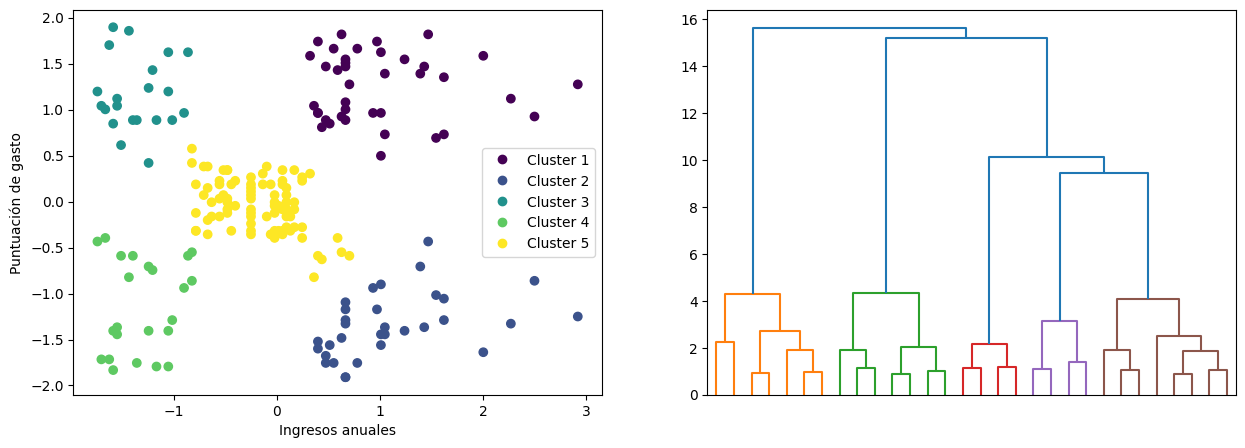

In [36]:
Z = linkage(cluster_df, method = 'ward')
labels = fcluster(Z, 5, criterion = 'maxclust')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

res = ax1.scatter(
    cluster_df[:, 0],
    cluster_df[:, 1],
    c = labels
)
ax1.set_xlabel('Ingresos anuales')
ax1.set_ylabel('Puntuación de gasto')

ax1.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1, 0.5)
)

dendrogram(
    Z,
    ax = ax2,
    truncate_mode = 'lastp',
    no_labels = True,
    color_threshold = 7
)

None

## Construcción de agrupamientos considerando el género

### Agrupamiento con k-medias _(k-means)_

#### Elección del conjunto de datos

En este paso vamos a dividir el conjunto de datos original según su campo `Genre`, para poder realizar un agrupamiento por separado para cada género y observar sus diferencias.

In [37]:
male_dataset = data[data['Genre'] == 'Male']
male_dataset.head()

,Genre,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
8,Male,64,19,3
10,Male,67,19,14
14,Male,37,20,13


In [38]:
female_dataset = data[data['Genre'] == 'Female']
female_dataset.head()

,Genre,Age,Annual Income,Spending Score
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
5,Female,22,17,76
6,Female,35,18,6


A continuación vamos a mostrar las mismas gráficas de puntos que realizamos en el primer agrupamiento por _k-means_, pero teniendo en cuenta los dos subconjuntos de datos.

##### Distribución de hombres

Text(970.81045751634, 0.5, 'Puntuación de gasto')

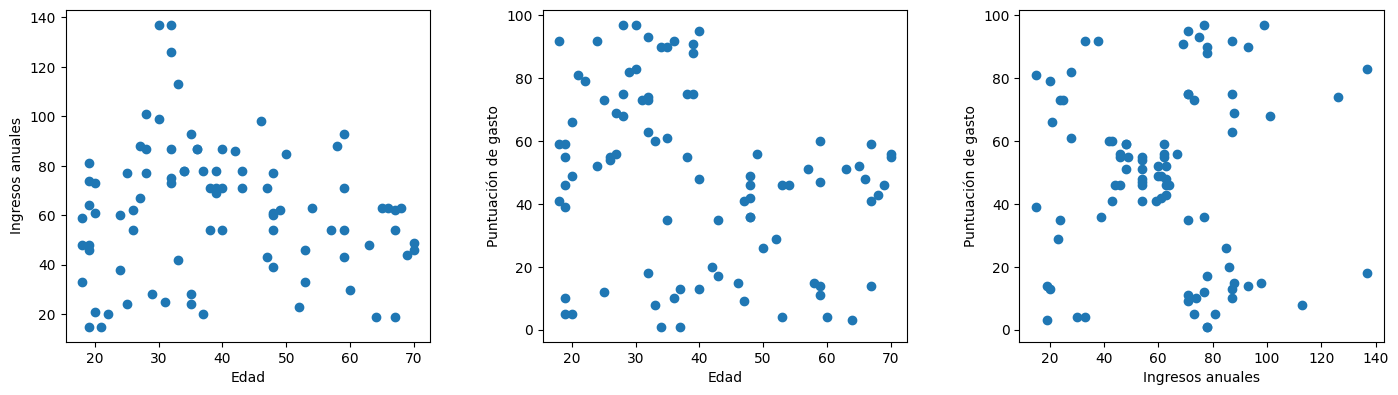

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)

ax1.scatter(male_dataset['Age'], male_dataset['Annual Income'])
ax1.set_xlabel('Edad')
ax1.set_ylabel('Ingresos anuales')

ax2.scatter(male_dataset['Age'], male_dataset['Spending Score'])
ax2.set_xlabel('Edad')
ax2.set_ylabel('Puntuación de gasto')

ax3.scatter(male_dataset['Annual Income'], male_dataset['Spending Score'])
ax3.set_xlabel('Ingresos anuales')
ax3.set_ylabel('Puntuación de gasto')

Observamos que la distribución de datos es similar a la del conjunto de datos original, por lo que podemos esperar un resultado similar al del agrupamiento anterior.

##### Distribución de mujeres

Text(970.81045751634, 0.5, 'Puntuación de gasto')

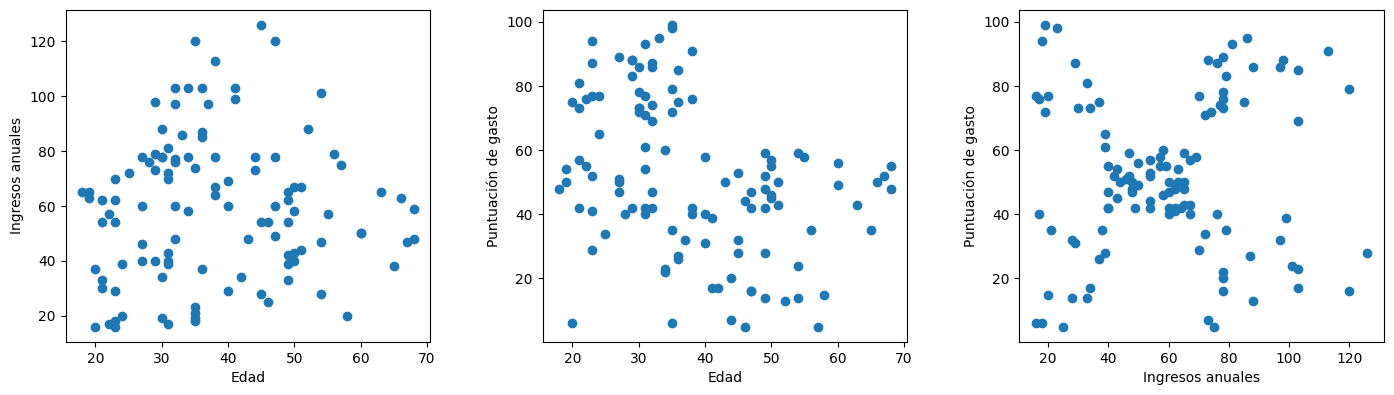

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)

ax1.scatter(female_dataset['Age'], female_dataset['Annual Income'])
ax1.set_xlabel('Edad')
ax1.set_ylabel('Ingresos anuales')

ax2.scatter(female_dataset['Age'], female_dataset['Spending Score'])
ax2.set_xlabel('Edad')
ax2.set_ylabel('Puntuación de gasto')

ax3.scatter(female_dataset['Annual Income'], female_dataset['Spending Score'])
ax3.set_xlabel('Ingresos anuales')
ax3.set_ylabel('Puntuación de gasto')

Se extraen las mismas conclusiones que en el caso anterior: La distribución de datos es próxima a la del conjunto de datos original.

#### Creación del agrupamiento

Para este par de agrupamientos _k-means_, calcularemos directamente el valor de
_K_ óptimo para cada subconjunto de datos.

In [41]:
k_values = np.arange(1, 10)
male_info_values = []
female_info_values = []

for i in k_values:
    male_info_values += [information_value(male_dataset[['Annual Income', 'Spending Score']], i)]
    female_info_values += [information_value(female_dataset[['Annual Income', 'Spending Score']], i)]

male_top_index = elbow_value(male_info_values)
female_top_index = elbow_value(female_info_values)

##### Cálculo del codo para hombres

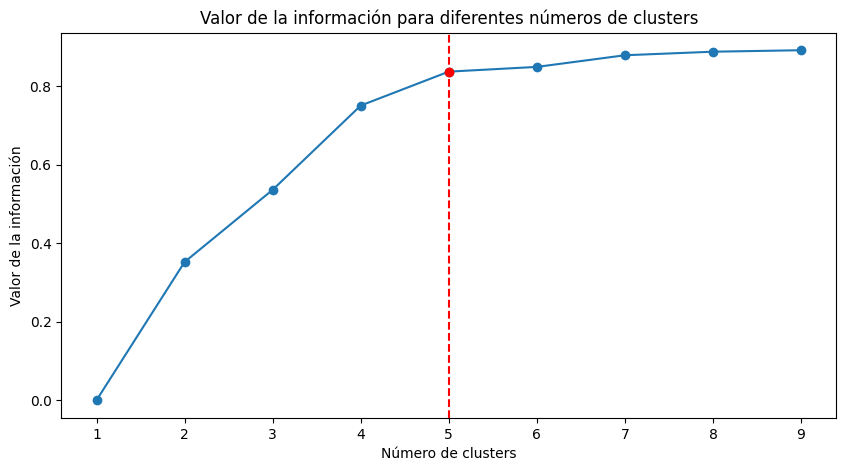

In [42]:
plot_elbow_chart(k_values, male_info_values, male_top_index)

##### Cálculo del codo para mujeres

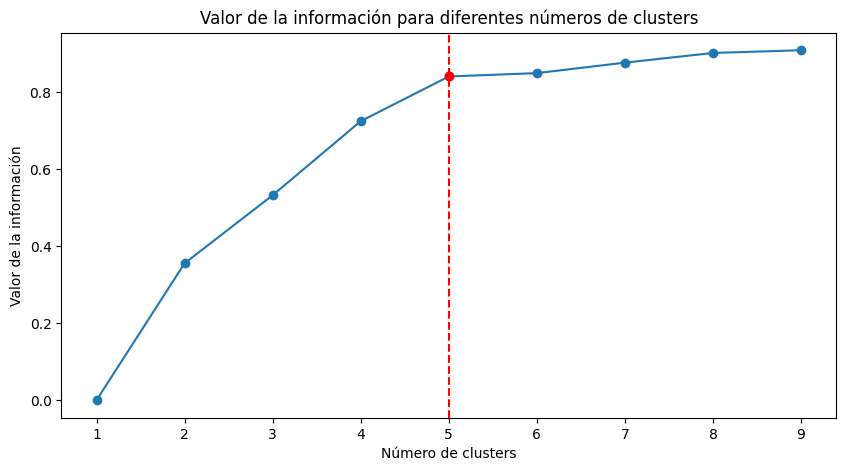

In [43]:
plot_elbow_chart(k_values, female_info_values, female_top_index)

##### Creación de ambos modelos

In [44]:
male_kmeans = KMeans(n_clusters = male_top_index + 1, random_state = 42, n_init = 'auto')
male_kmeans.fit(male_dataset[['Annual Income', 'Spending Score']])

female_kmeans = KMeans(n_clusters = female_top_index + 1, random_state = 42, n_init = 'auto')
female_kmeans.fit(female_dataset[['Annual Income', 'Spending Score']])

male_labels = male_kmeans.labels_
female_labels = female_kmeans.labels_

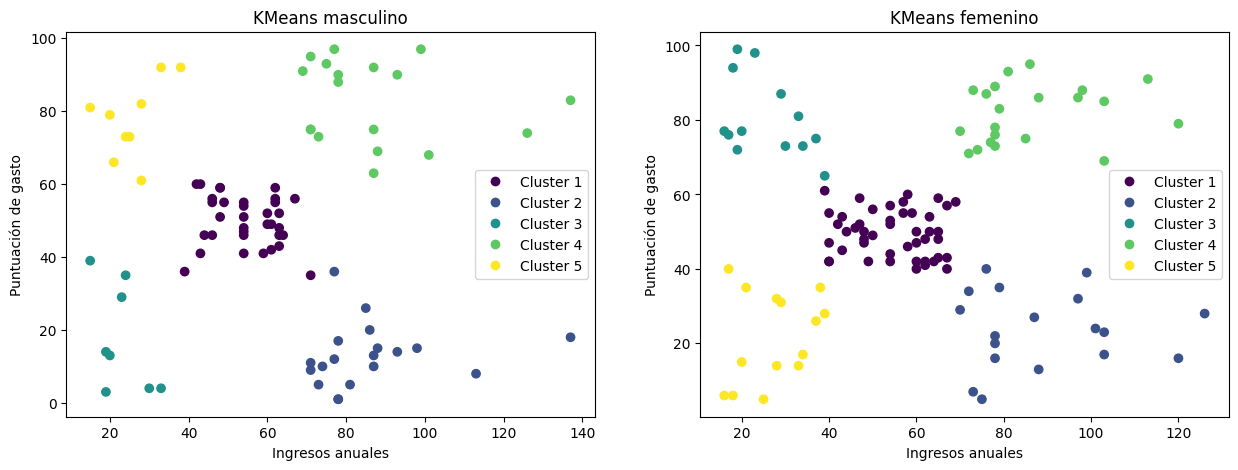

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

res = ax1.scatter(
    male_dataset['Annual Income'],
    male_dataset['Spending Score'],
    c = male_labels
)
ax1.set_title('KMeans masculino')
ax1.set_xlabel('Ingresos anuales')
ax1.set_ylabel('Puntuación de gasto')
ax1.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1, 0.5)
)

res = ax2.scatter(
    female_dataset['Annual Income'],
    female_dataset['Spending Score'],
    c = female_labels
)
ax2.set_title('KMeans femenino')
ax2.set_xlabel('Ingresos anuales')
ax2.set_ylabel('Puntuación de gasto')
ax2.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1, 0.5)
)

#### Evaluación del agrupamiento

Para evaluar ambos agrupamientos, graficaremos sus coeficientes de silueta.

##### Silueta masculina

0.5683843009270295


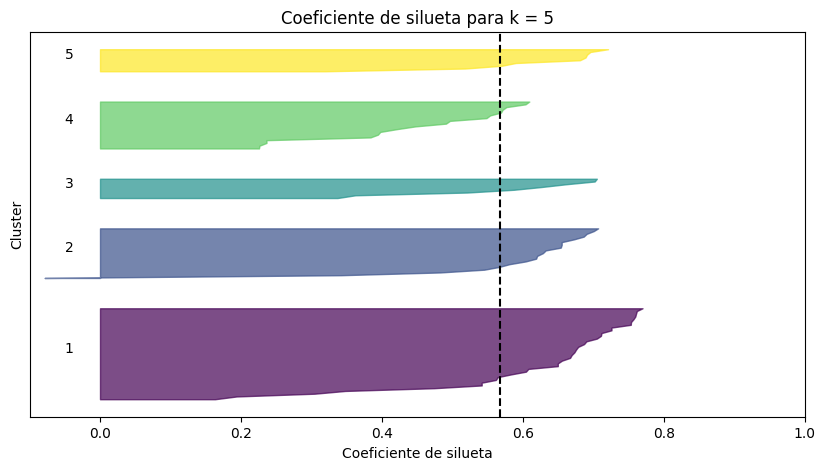

In [46]:
male_sil_avg = silhouette_score(male_dataset[['Annual Income', 'Spending Score']], male_labels)
male_sil_values = silhouette_samples(male_dataset[['Annual Income', 'Spending Score']], male_labels)

plot_silhouette(5, male_sil_values, male_sil_avg, male_labels)
print(male_sil_avg)

##### Silueta femenina

0.5412567065724394


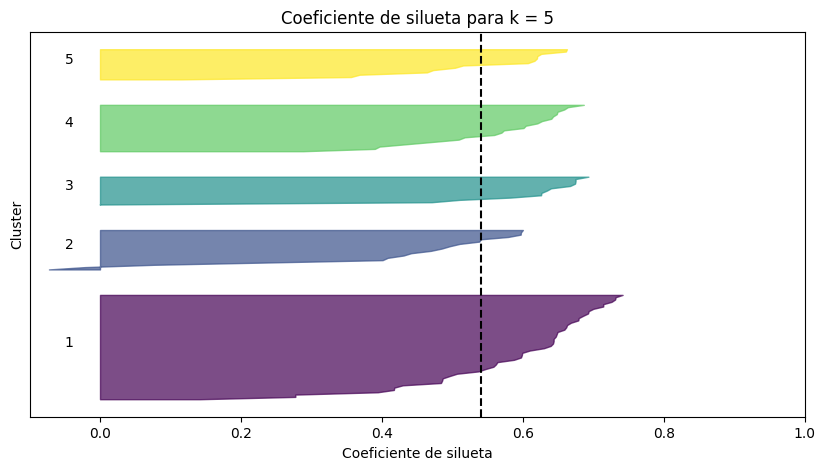

In [47]:
female_sil_avg = silhouette_score(female_dataset[['Annual Income', 'Spending Score']], female_labels)
female_sil_values = silhouette_samples(female_dataset[['Annual Income', 'Spending Score']], female_labels)
 
plot_silhouette(5, female_sil_values, female_sil_avg, female_labels)
print(female_sil_avg)

### Agrupamiento jerárquico

#### Elección de subconjunto de datos

Para el agrupamiento jerárquico, vamos a utilizar las mismas variables que para el agrupamiento con k-medias.

#### Creación del modelo

Realizaremos la misma operación que hicimos en el agrupamiento jerárquico anterior, pero esta vez para cada subconjunto de datos.

##### Cálculo cofenético para hombres

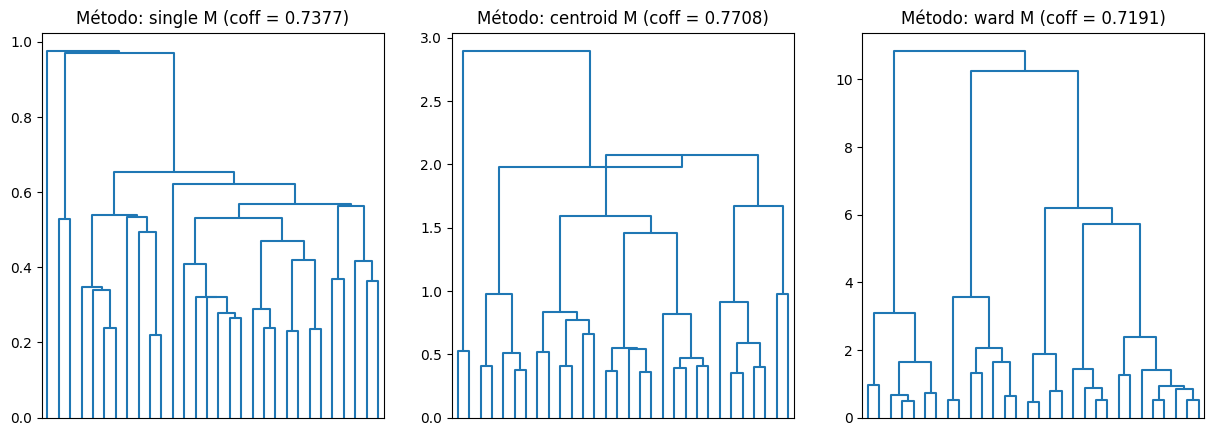

In [48]:
scaler = StandardScaler()
male_cluster_df = scaler.fit_transform(male_dataset[['Annual Income', 'Spending Score']])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

subgraphs = [ax1, ax2, ax3]
method_list = ['single', 'centroid', 'ward']

for i, method in enumerate(method_list):
    Z = linkage(male_cluster_df, method = method)
    cophenet_val = cophenet(Z, pdist(male_cluster_df))[0]

    subgraphs[i].set_title(f'Método: {method} M (coff = {cophenet_val:.4f})')
    dendrogram(
        Z,
        ax = subgraphs[i],
        truncate_mode = 'lastp',
        no_labels = True,
        color_threshold = 0
    )

##### Cálculo cofenético para mujeres

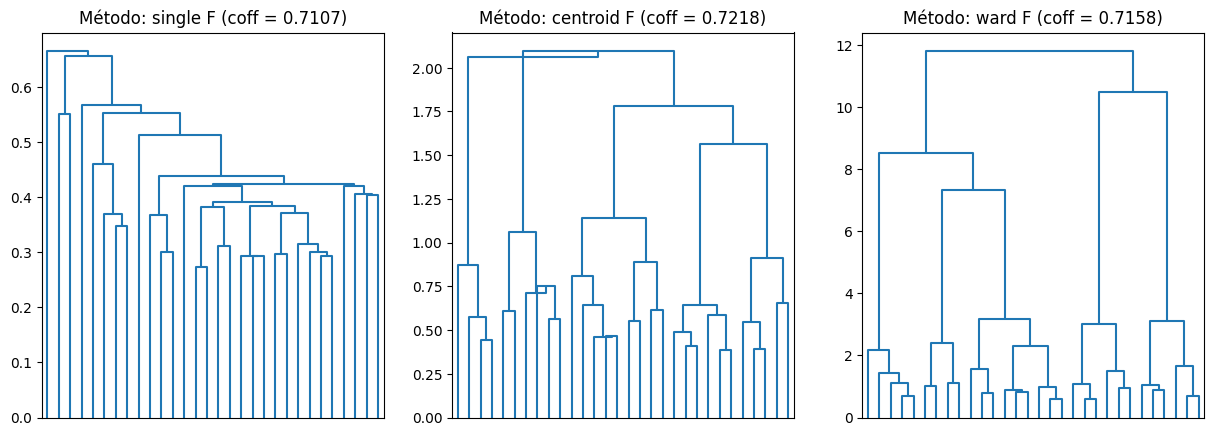

In [49]:
scaler = StandardScaler()
female_cluster_df = scaler.fit_transform(female_dataset[['Annual Income', 'Spending Score']])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

subgraphs = [ax1, ax2, ax3]
method_list = ['single', 'centroid', 'ward']

for i, method in enumerate(method_list):
    Z = linkage(female_cluster_df, method = method)
    cophenet_val = cophenet(Z, pdist(female_cluster_df))[0]

    subgraphs[i].set_title(f'Método: {method} F (coff = {cophenet_val:.4f})')
    dendrogram(
        Z,
        ax = subgraphs[i],
        truncate_mode = 'lastp',
        no_labels = True,
        color_threshold = 0
    )

#### Evaluación del modelo

Como podemos observar en los gráficos anteriores, tanto el subconjunto de hombres como el de mujeres tienen su coeficiente cofenético máximo para el método de enlace _centroid_, siendo estos de:

* $0.77$ para los hombres
* $0.72$ para las mujeres

Como hicimos en el primer agrupamiento jerárquico, graficaremos los tres métodos para cada subconjunto de datos para observar cómo se comportan.

##### Gráficos de enlace para hombres

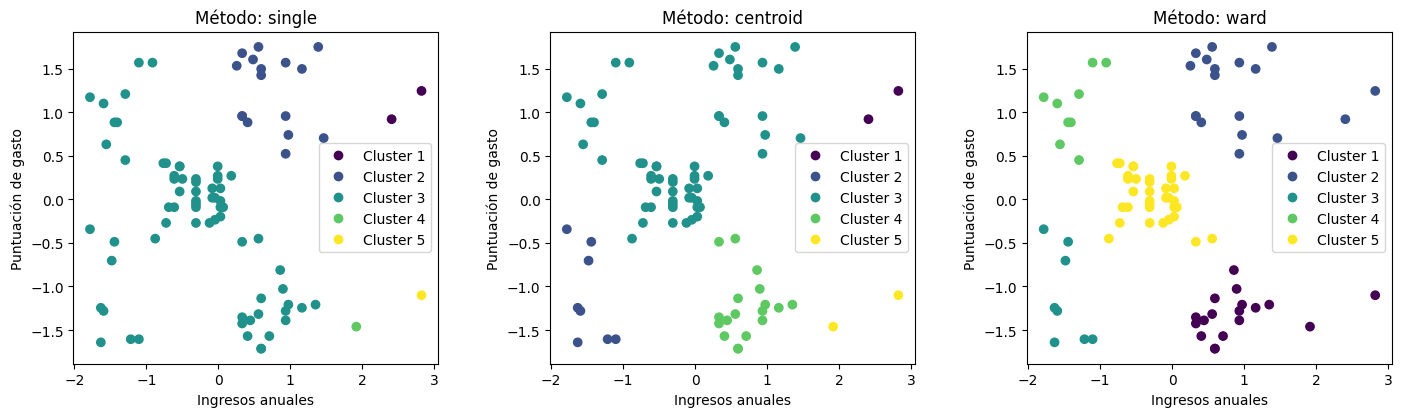

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)
ax = [ax1, ax2, ax3]

for i, method in enumerate(method_list):
    Z = linkage(male_cluster_df, method = method)
    labels = fcluster(Z, 5, criterion = 'maxclust')

    res = ax[i].scatter(
        male_cluster_df[:, 0],
        male_cluster_df[:, 1],
        c = labels
    )
    ax[i].set_title(f'Método: {method}')
    ax[i].set_xlabel('Ingresos anuales')
    ax[i].set_ylabel('Puntuación de gasto')

    ax[i].legend(
        handles = res.legend_elements()[0],
        labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
        loc = 'center right',
        bbox_to_anchor = (1, 0.5)
    )

Vemos que el agrupamiento por _centroid_ da un agrupamiento aparentemente correcto, pero con ciertos grupos que parecen estar mal definidos. Por otro lado, el agrupamiento por _ward_ parece ser el que mejor define los grupos, pero con un coeficiente cofenético menor.

Como en el primer agrupamiento jerárquico, nos quedaremos con el método _ward_.

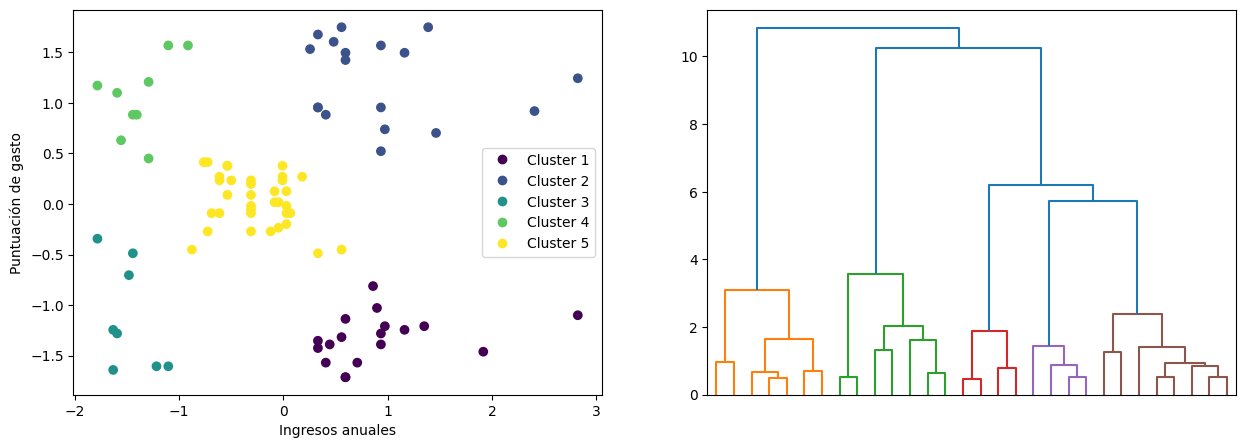

In [53]:
Z = linkage(male_cluster_df, method = 'ward')
labels = fcluster(Z, 5, criterion = 'maxclust')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

res = ax1.scatter(
    male_cluster_df[:, 0],
    male_cluster_df[:, 1],
    c = labels
)

ax1.set_xlabel('Ingresos anuales')
ax1.set_ylabel('Puntuación de gasto')

ax1.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1, 0.5)
)

dendrogram(
    Z,
    ax = ax2,
    truncate_mode = 'lastp',
    no_labels = True,
    color_threshold = 4
)

None

##### Gráficos de enlace para mujeres

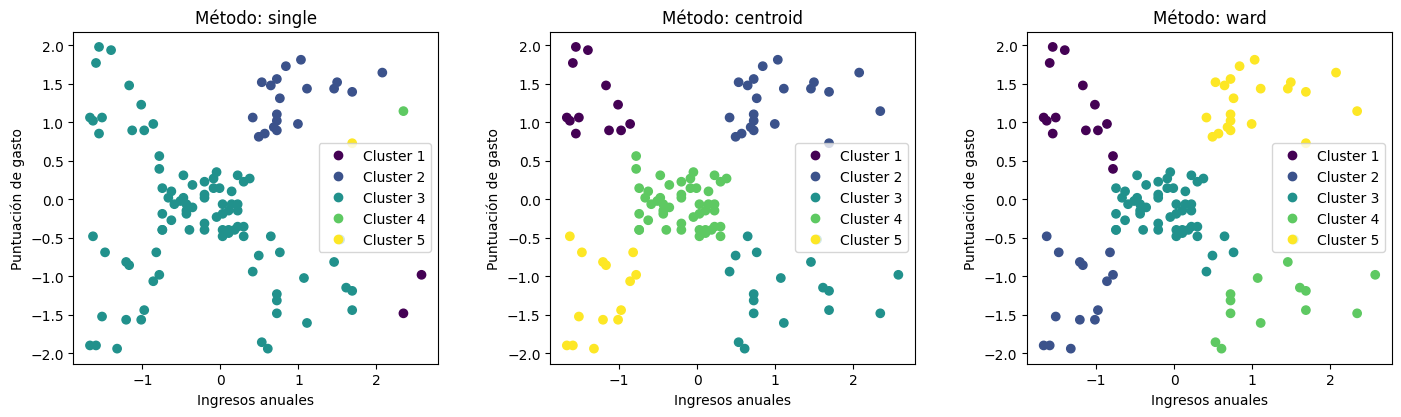

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout(pad = 5.0)
ax = [ax1, ax2, ax3]

for i, method in enumerate(method_list):
    Z = linkage(female_cluster_df, method = method)
    labels = fcluster(Z, 5, criterion = 'maxclust')

    res = ax[i].scatter(
        female_cluster_df[:, 0],
        female_cluster_df[:, 1],
        c = labels
    )
    ax[i].set_title(f'Método: {method}')
    ax[i].set_xlabel('Ingresos anuales')
    ax[i].set_ylabel('Puntuación de gasto')

    ax[i].legend(
        handles = res.legend_elements()[0],
        labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
        loc = 'center right',
        bbox_to_anchor = (1, 0.5)
    )

Vemos que al contrario que en el caso anterior y en el caso del agrupamiento genérico, el método con mayor coeficiente cofenético coincide con el método que en la práctica produce los grupos más correctos: El _centroid_. Por tanto, nos quedaremos con este método.

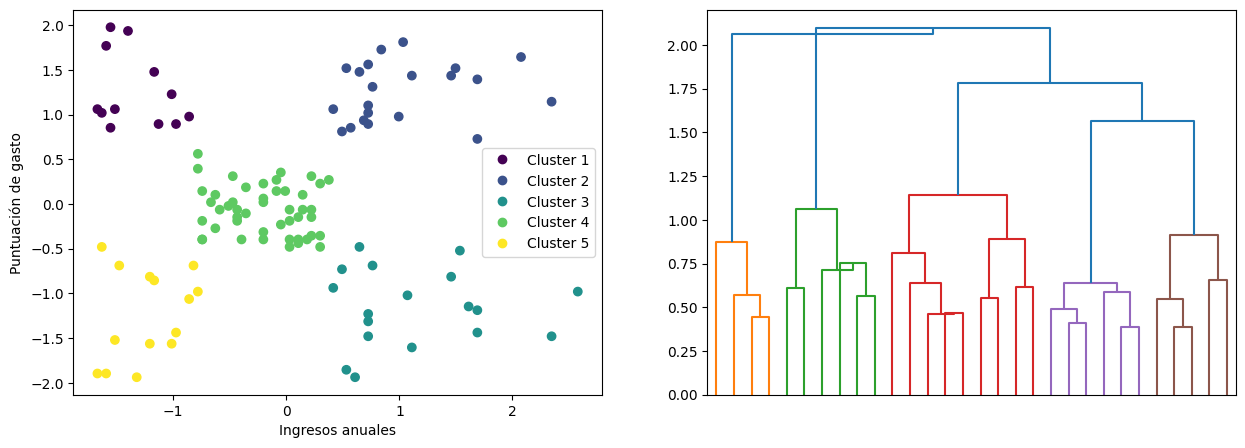

In [56]:
Z = linkage(female_cluster_df, method = 'centroid')
labels = fcluster(Z, 5, criterion = 'maxclust')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

res = ax1.scatter(
    female_cluster_df[:, 0],
    female_cluster_df[:, 1],
    c = labels
)

ax1.set_xlabel('Ingresos anuales')
ax1.set_ylabel('Puntuación de gasto')

ax1.legend(
    handles = res.legend_elements()[0],
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
    loc = 'center right',
    bbox_to_anchor = (1, 0.5)
)

dendrogram(
    Z,
    ax = ax2,
    truncate_mode = 'lastp',
    no_labels = True,
    color_threshold = 1.25
)

None